<a href="https://colab.research.google.com/github/TJConnellyContingentMacro/NU422/blob/master/Connelly_Terrence_Assignment_4_RandomForests.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Evaluating Regression Models using Boston Housing Study**

Use all explanatory variables (with the exception of neighborhood) and all 506 census tract observations from the Boston Housing Study. 

Use one of two response variables: (1) **the median value of homes in thousands of 1970 dollars or (2) the log median value of homes in thousands of 1970 dollars.** 

Employ** at least two regression modeling methods selected from those discussed in Chapter 4 of the Géron (2017) textbook: linear regression, ridge regression, lasso regression, and elastic net. **

Evaluate these methods within a cross-validation design, using root mean-squared error (RMSE) as an index of prediction error. Python scikit-learn should be your primary environment for conducting this research. Note that it is not necessary to employ polynomial regression in this assignment.

**Try alternative versions of random forests and gradient boosting. Select a best modeling method for the Boston Housing Study. Employ that method on the full data set, obtaining results that you can report to management.**

Regarding the management problem, imagine that you again are advising a real estate brokerage firm in its attempt to employ machine learning methods. The firm wants to use machine learning to complement conventional methods for assessing the market value of residential real estate. **Of the modeling methods examined in your study, which would you recommend to management and why? Reviewing the results of the random forests and gradient boosting model you have selected to present to management, which explanatory variables are most important in predicting home prices?**
**bold text**
### **Useful references I found while doing this:**

https://towardsdatascience.com/a-beginners-guide-to-linear-regression-in-python-with-scikit-learn-83a8f7ae2b4f

https://medium.com/diogo-menezes-borges/a-breath-of-fresh-air-with-decision-trees-e660455bbfc8

####  Libraries and Modules Used

In [2]:
import pandas as pd  # data frame operations  
import numpy as np  # arrays and math functions
import matplotlib.pyplot as plt  # static plotting
%matplotlib inline

import seaborn as sns  # pretty plotting, including heat map
plt.style.use('fivethirtyeight')

# correlation heat map setup for seaborn
def corr_chart(df_corr):
    corr=df_corr.corr()
    #screen top half to get a triangle
    top = np.zeros_like(corr, dtype=np.bool)
    top[np.triu_indices_from(top)] = True
    fig=plt.figure()
    fig, ax = plt.subplots(figsize=(10,10))
    sns.heatmap(corr, mask=top, cmap='coolwarm', 
        center = 0, square=True, 
        linewidths=.5, cbar_kws={'shrink':.5}, 
        annot = True, annot_kws={'size': 9}, fmt = '.3f')           
    plt.xticks(rotation=45) # rotate variable labels on columns (x axis)
    plt.yticks(rotation=0) # use horizontal variable labels on rows (y axis)
    plt.title('Correlation Heat Map')   
    plt.savefig('plot-corr-map.png', 
        bbox_inches = 'tight', dpi=None, facecolor='w', edgecolor='b', 
        orientation='portrait', papertype=None, format=None, 
        transparent=True, pad_inches=0.25, frameon=None)      

np.set_printoptions(precision=3)


from sklearn.preprocessing import OrdinalEncoder

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

# BernoulliNB is designed for binary/boolean features
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression

from sklearn.metrics import roc_auc_score   
from sklearn.model_selection import KFold
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso, LassoCV
from sklearn.linear_model import SGDRegressor
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import DecisionTreeRegressor

from sklearn.ensemble import BaggingClassifier
from sklearn.tree import export_graphviz


from yellowbrick.classifier import ConfusionMatrix
from yellowbrick.regressor import ManualAlphaSelection
from yellowbrick.regressor import AlphaSelection, PredictionError, ResidualsPlot

from sklearn.pipeline import Pipeline



from sklearn.preprocessing import PolynomialFeatures
poly_features = PolynomialFeatures(degree=2, include_bias=False)




import warnings
warnings.filterwarnings("ignore")

# import base packages into the namespace for this program
import numpy as np
import pandas as pd

import os

PROJECT_ROOT_DIR = ""
CHAPTER_ID = ""

def save_fig(fig_id, tight_layout=True):
    path = os.path.join(PROJECT_ROOT_DIR, "", fig_id + ".png")
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format='png', dpi=300)
    
def image_path(fig_id):
    return os.path.join(PROJECT_ROOT_DIR, "", CHAPTER_ID, fig_id)

print("All Packages and a Correlation Chart function loaded.  WARNING - this was created in April, 2019 and warnings were supressed.")

All Packages and a Correlation Chart function loaded.  WARNING - this was created in April, 2019 and warnings were supressed.


# Ingest

In [3]:
bos = pd.read_csv('https://github.com/GoPackers/NU422/raw/GoPackers-NU422-Wk3-Boston-Hsg-and-Regression/boston.csv')  
# examine the shape of original input data
print(bos.shape)
print(bos.dropna().shape)
bos = bos.drop(['neighborhood'], axis = 1)

(506, 14)
(506, 14)


# Exploratory Data Analysis

In [4]:
bos.head()


,crim,zn,indus,chas,nox,rooms,age,dis,rad,tax,ptratio,lstat,mv
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,5.33,36.2



**mv** Median value of homes in thousands of 1970 dollars    **nox** Air pollution (nitrogen oxide concentration)

**crim** Crime rate **zn** Percent of land zoned for lots  **indus** Percent of business that is industrial or nonretail

**chas** On the Charles River (1) or not (0)  **rooms** Average number of rooms per home

**age** Percentage of homes built before 1940  **dis** Weighted distance to employment centers

**rad** Accessibility to radial highways  **tax** Tax rate

**ptratio** Pupil/teacher ratio in public schools  **lstat** Percentage of population of lower socio-economic status

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f0447a24898>,
      dtype=object)

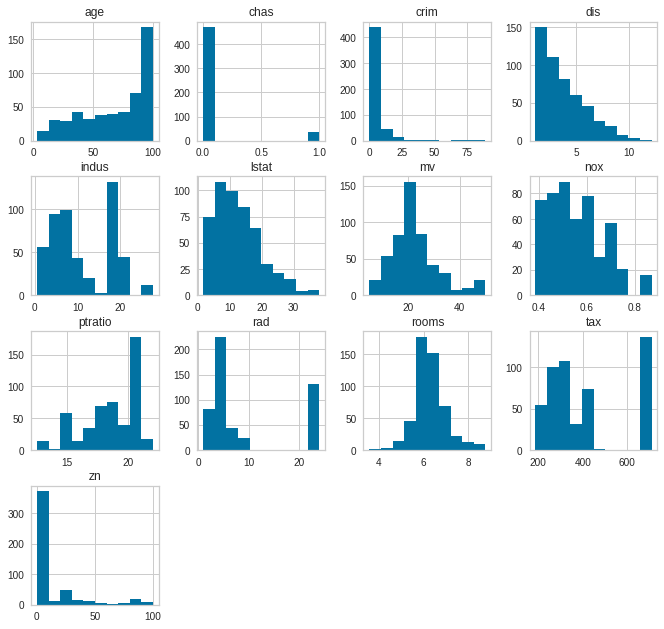

In [5]:
bos.hist(bins = 10,figsize=(10,10))

# Research Design and Modeling Methods

### Now let's plot the potential independent/explanatory variables against our response variable, home values (home value on x-axis).



*   We see good potential fit with rooms and "lstat", the percentage of lower socioeconomic households in the area. 
*   there is a small relationship with zoning and "ptratio", the pupil to student ratios at the nearby schools.   


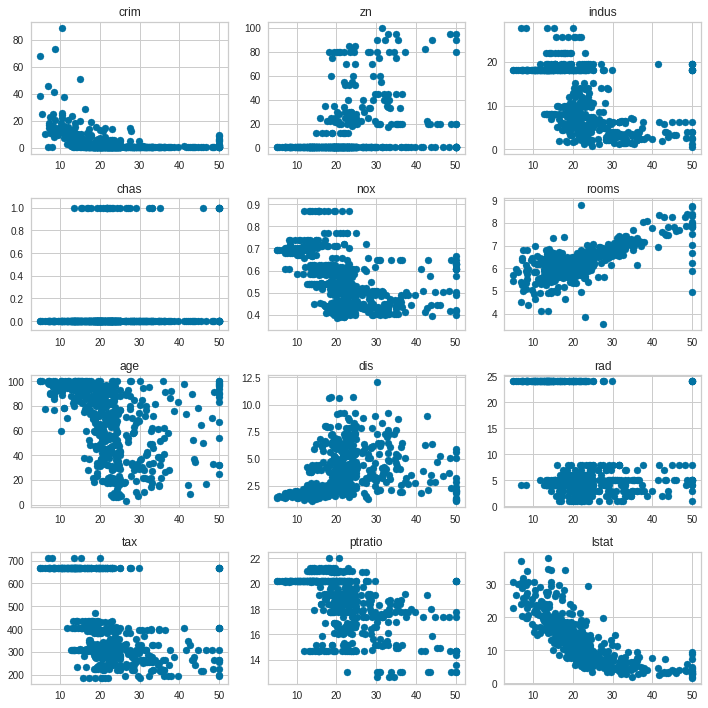

In [6]:
#@title
fig = plt.figure(figsize = (10,10))
columns = 3
rows = 4
for i in range(len(bos.columns)-1):
           plt.subplot(rows, columns, i+1)
           plt.scatter(bos['mv'], bos.iloc[:,i:i+1])
           plt.title(bos.columns[i])
plt.tight_layout()
plt.show()


***There appears to be an outlier or possible "plug" figure at 49k in market value.  Let's drop datapoints greater than or equal to 49k.  There are only 16, so dataset will now be 490. And then we'll plot again**

In [7]:
bos.describe()

,crim,zn,indus,chas,nox,rooms,age,dis,rad,tax,ptratio,lstat,mv
count,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000
mean,3.613524,11.363636,11.136779,0.069170,0.554695,6.284634,68.574901,3.795043,9.549407,408.237154,18.455534,12.653063,22.528854
std,8.601545,23.322453,6.860353,0.253994,0.115878,0.702617,28.148861,2.105710,8.707259,168.537116,2.164946,7.141062,9.182176
min,0.006320,0.000000,0.460000,0.000000,0.385000,3.561000,2.900000,1.129600,1.000000,187.000000,12.600000,1.730000,5.000000
25%,0.082045,0.000000,5.190000,0.000000,0.449000,5.885500,45.025000,2.100175,4.000000,279.000000,17.400000,6.950000,17.025000
50%,0.256510,0.000000,9.690000,0.000000,0.538000,6.208500,77.500000,3.207450,5.000000,330.000000,19.050000,11.360000,21.200000
75%,3.677082,12.500000,18.100000,0.000000,0.624000,6.623500,94.075000,5.188425,24.000000,666.000000,20.200000,16.955000,25.000000
max,88.976200,100.000000,27.740000,1.000000,0.871000,8.780000,100.000000,12.126500,24.000000,711.000000,22.000000,37.970000,50.000000


In [8]:
bos[bos['mv']>=49].count()


crim       16
zn         16
indus      16
chas       16
nox        16
rooms      16
age        16
dis        16
rad        16
tax        16
ptratio    16
lstat      16
mv         16
dtype: int64

## Evaluate and remove outliers, ultimately cut dataset down to 358

In [9]:
bos2 = bos[(bos['mv'] < 49)]
bos2.describe()


,crim,zn,indus,chas,nox,rooms,age,dis,rad,tax,ptratio,lstat,mv
count,490.000000,490.000000,490.000000,490.000000,490.000000,490.000000,490.00000,490.000000,490.000000,490.000000,490.000000,490.00000,490.000000
mean,3.643241,11.112245,11.113143,0.059184,0.554307,6.245471,68.27898,3.834519,9.514286,408.002041,18.520000,12.92402,21.631837
std,8.722154,22.844626,6.821302,0.236209,0.116688,0.653147,28.16479,2.109948,8.691297,168.065190,2.110478,7.08318,7.846800
min,0.006320,0.000000,0.740000,0.000000,0.385000,3.561000,2.90000,1.137000,1.000000,187.000000,12.600000,1.98000,5.000000
25%,0.082045,0.000000,5.190000,0.000000,0.449000,5.881000,44.55000,2.111050,4.000000,280.250000,17.400000,7.34750,16.700000
50%,0.247510,0.000000,9.690000,0.000000,0.538000,6.185000,76.80000,3.275900,5.000000,330.000000,19.100000,11.67500,20.900000
75%,3.647422,12.500000,18.100000,0.000000,0.624000,6.578000,93.87500,5.214600,24.000000,666.000000,20.200000,17.11750,24.600000
max,88.976200,100.000000,27.740000,1.000000,0.871000,8.780000,100.00000,12.126500,24.000000,711.000000,22.000000,37.97000,48.800000


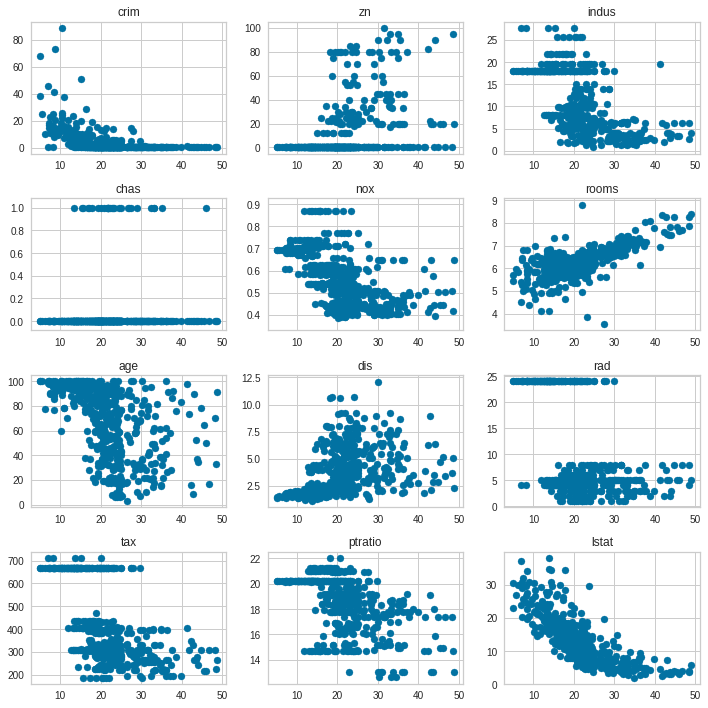

In [10]:

fig = plt.figure(figsize = (10,10))
columns = 3
rows = 4
for i in range(len(bos2.columns)-1):
           plt.subplot(rows, columns, i+1)
           plt.scatter(bos2['mv'], bos2.iloc[:,i:i+1])
           plt.title(bos2.columns[i])
plt.tight_layout()
plt.show()

In [11]:
bos2 = bos[(bos['mv'] < 49) & (bos['rad'] <= 24) & (bos['tax'] < 600)]
bos2.describe()

,crim,zn,indus,chas,nox,rooms,age,dis,rad,tax,ptratio,lstat,mv
count,358.000000,358.000000,358.000000,358.000000,358.000000,358.000000,358.000000,358.000000,358.000000,358.000000,358.000000,358.000000,358.000000
mean,0.376563,15.209497,8.402346,0.067039,0.511169,6.335726,60.377095,4.479447,4.452514,312.245810,17.901955,10.622123,24.091899
std,0.620910,25.541107,5.926865,0.250440,0.101593,0.606355,28.209364,2.102061,1.643843,67.303451,2.163090,5.794361,7.148455
min,0.006320,0.000000,0.740000,0.000000,0.385000,4.903000,2.900000,1.321600,1.000000,187.000000,12.600000,1.980000,11.800000
25%,0.060543,0.000000,4.050000,0.000000,0.437225,5.926250,35.950000,2.742600,4.000000,270.000000,16.600000,6.360000,19.400000
50%,0.130875,0.000000,6.660000,0.000000,0.493000,6.218500,61.900000,4.090250,4.000000,304.000000,18.100000,9.500000,22.600000
75%,0.350705,22.000000,10.010000,0.000000,0.544000,6.635000,87.375000,5.957925,5.000000,380.500000,19.200000,13.495000,27.400000
max,4.097400,100.000000,25.650000,1.000000,0.871000,8.398000,100.000000,12.126500,8.000000,469.000000,22.000000,34.410000,48.800000


# Modelling and Analysis

<Figure size 576x396 with 0 Axes>

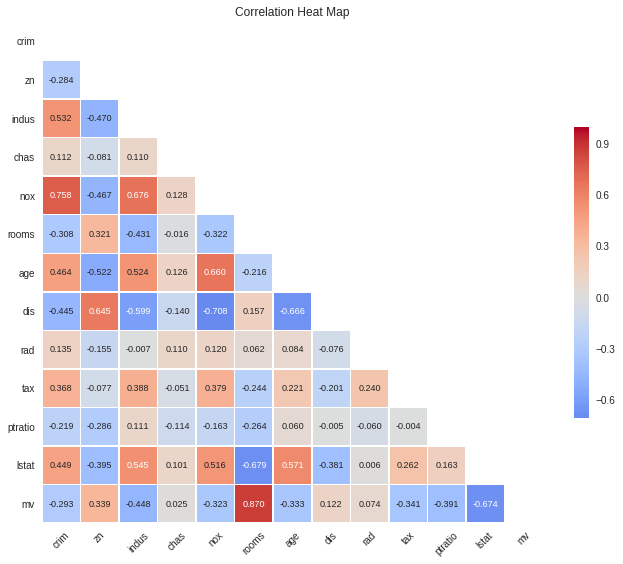

In [12]:
corr_chart(bos2)  

**Now create matrix and convert market value to log**

In [0]:
# set up preliminary data for data for fitting the models 
# the first column is the log median housing value response
# the raemaining columns are the explanatory variables
prelim_model_data = np.array([np.log(bos2.mv),\
   bos2.crim,\
    bos2.zn,\
    bos2.indus,\
    bos2.chas,\
    bos2.nox,\
    bos2.rooms,\
    bos2.age,\
    bos2.dis,\
    bos2.rad,\
    bos2.tax,\
    bos2.ptratio,\
    bos2.lstat]).T

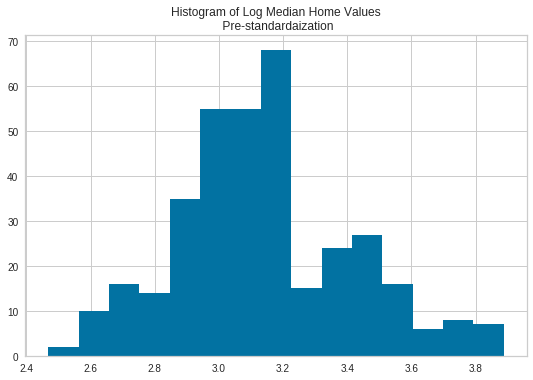

In [14]:
plt.hist(prelim_model_data[:,0], bins = 'auto')
plt.title('Histogram of Log Median Home Values\n Pre-standardaization')
plt.savefig('Hist-Log-Median-Home-Values.pdf', 
    bbox_inches = 'tight', dpi=None, facecolor='w', edgecolor='b', 
    orientation='portrait', papertype=None, format=None, 
    transparent=True, pad_inches=0.25, frameon=None)
plt.show()

##Random Forests

In [0]:
X = np.delete(prelim_model_data, -1, axis = 1)
y = prelim_model_data[:,0]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size =0.2, random_state=11)


In [20]:
from sklearn.ensemble import RandomForestRegressor

rnd_reg = RandomForestRegressor(n_estimators=100, max_features = 'log2', bootstrap = True)
regfit = rnd_reg.fit(X_train, y_train)
regfit

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='log2', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

**Sample of What one of the Trees looks like:**
**bold text**



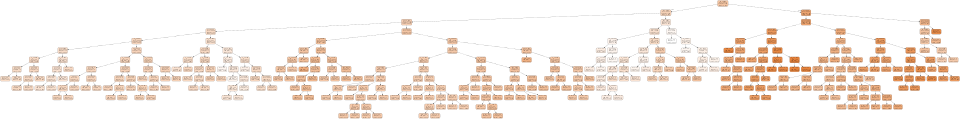

In [21]:
from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus
dot_data = StringIO()
export_graphviz(rnd_reg.estimators_[5], out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue()) 
graph.set_size('"10,20!"')
Image(graph.create_png())

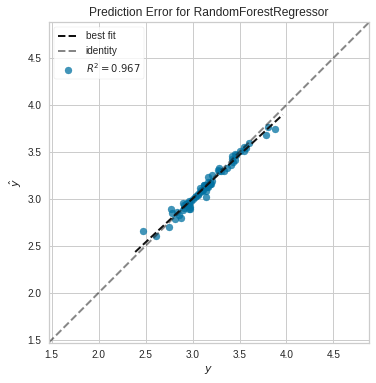

In [22]:
visualizer = PredictionError(rnd_reg)

visualizer.fit(X_train, y_train)  # Fit the training data to the visualizer
visualizer.score(X_test, y_test)  # Evaluate the model on the test data
g = visualizer.poof()   

In [0]:


import matplotlib as mpl

In [0]:
def plot_digit(data):
    image = data.reshape(1,12)
    plt.imshow(image, cmap = plt.cm.hot,
               interpolation="nearest")
    plt.axis("off")

Saving figure Heat Map  - Left to Right: crim	zn	indus	chas	nox	rooms	age	dis	rad	tax	ptratio	lstat	


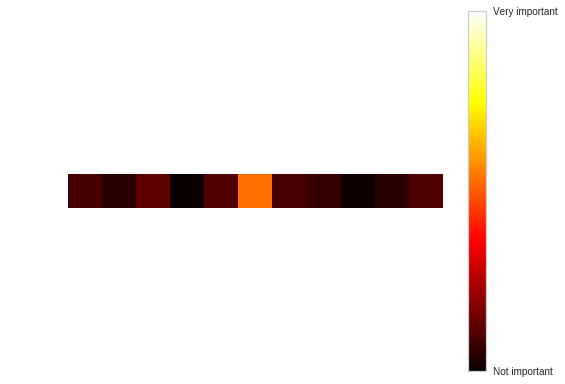

In [38]:
plot_digit(rnd_reg.feature_importances_)

cbar = plt.colorbar(ticks=[rnd_reg.feature_importances_.min(), rnd_reg.feature_importances_.max()])
cbar.ax.set_yticklabels(['Not important', 'Very important'])


save_fig("Heat Map  - Left to Right: crim	zn	indus	chas	nox	rooms	age	dis	rad	tax	ptratio	lstat	")
plt.show()

In [52]:
rnd_reg.feature_importances_

array([0.442, 0.04 , 0.022, 0.057, 0.002, 0.05 , 0.235, 0.042, 0.033,
       0.007, 0.023, 0.047])

### Gradient Boosting

In [39]:
from sklearn.ensemble import GradientBoostingRegressor


gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=100, learning_rate=1.0, random_state=42)
gbrt.fit(X, y)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=1.0, loss='ls', max_depth=2, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=100, n_iter_no_change=None, presort='auto',
             random_state=42, subsample=1.0, tol=0.0001,
             validation_fraction=0.1, verbose=0, warm_start=False)

In [56]:
gbrt_slow = GradientBoostingRegressor(max_depth=2, n_estimators=200, learning_rate=0.1, random_state=42)
gbrt_slow.fit(X, y)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=2, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=200, n_iter_no_change=None, presort='auto',
             random_state=42, subsample=1.0, tol=0.0001,
             validation_fraction=0.1, verbose=0, warm_start=False)

In [41]:
gbrt.predict

<bound method GradientBoostingRegressor.predict of GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=1.0, loss='ls', max_depth=2, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=100, n_iter_no_change=None, presort='auto',
             random_state=42, subsample=1.0, tol=0.0001,
             validation_fraction=0.1, verbose=0, warm_start=False)>

In [0]:

import plotly 
plotly.tools.set_credentials_file(username='NUTJC', api_key='FMnzsnTb5FMEXfCz9Qnu')

In [44]:
import plotly.plotly as py
from sklearn.metrics import mean_squared_error

params = {'n_estimators': 500, 'max_depth': 4, 'min_samples_split': 2,
          'learning_rate': 0.01, 'loss': 'ls'}
clf = GradientBoostingRegressor(**params)

clf.fit(X_train, y_train)
mse = mean_squared_error(y_test, clf.predict(X_test))
print("MSE: %.4f" % mse)



MSE: 0.0001


In [0]:
import plotly.graph_objs as go

test_score = np.zeros((params['n_estimators'],), dtype=np.float64)

for i, y_pred in enumerate(clf.staged_predict(X_test)):
    test_score[i] = clf.loss_(y_test, y_pred)


train = go.Scatter(x=np.arange(params['n_estimators']) + 1, 
                   y=clf.train_score_, 
                   name='Training Set Deviance',
                   mode='lines',
                   line=dict(color='blue')
                  )
test = go.Scatter(x=np.arange(params['n_estimators']) + 1, 
                  y=test_score, 
                  mode='lines',
                  name='Test Set Deviance',
                  line=dict(color='red')
                 )

layout = go.Layout(title='Deviance',
                   xaxis=dict(title='Boosting Iterations'),
                   yaxis=dict(title='Deviance')
                  )
fig = go.Figure(data=[test, train], layout=layout)

Relatively slow learning rate:

In [46]:
py.iplot(fig)

Now use faster learning rate:


In [53]:
params = {'n_estimators': 500, 'max_depth': 4, 'min_samples_split': 2,
          'learning_rate': 1.0, 'loss': 'ls'}
clf = GradientBoostingRegressor(**params)

clf.fit(X_train, y_train)
mse = mean_squared_error(y_test, clf.predict(X_test))
print("MSE: %.4f" % mse)

MSE: 0.0009


In [55]:
test_score = np.zeros((params['n_estimators'],), dtype=np.float64)

for i, y_pred in enumerate(clf.staged_predict(X_test)):
    test_score[i] = clf.loss_(y_test, y_pred)


train = go.Scatter(x=np.arange(params['n_estimators']) + 1, 
                   y=clf.train_score_, 
                   name='Training Set Deviance',
                   mode='lines',
                   line=dict(color='blue')
                  )
test = go.Scatter(x=np.arange(params['n_estimators']) + 1, 
                  y=test_score, 
                  mode='lines',
                  name='Test Set Deviance',
                  line=dict(color='red')
                 )

layout = go.Layout(title='Deviance',
                   xaxis=dict(title='Boosting Iterations'),
                   yaxis=dict(title='Deviance')
                  )
fig = go.Figure(data=[test, train], layout=layout)
py.iplot(fig)

#Conclusion & Management Recommendations


*   Management should consider using Random Forest Regressions to dramatically enhance the predictabive power of its traditional and machine learning models.   

* Additionally, it should consider a Gradient Boosting Regressor with a relatively slow learning rate stopping in the area of 50-100 iterations. 













